<a href="https://colab.research.google.com/github/kategimranova/ego_network_analysis/blob/main/vk_analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest

In [ ]:
import warnings
warnings.filterwarnings('ignore')

For the Social network project I decided to make analysis of my ego-network of the social network *VK.com* (https://vk.com). For collecting data I used the official API (https://vk.com/dev/first_guide). Code for data collecting is located in file *collect_data_from_vk.ipynb*, data analysis - in *vk_analyze.ipynb*. 

*  My ego-graph is an undirected graph, because 
there is friendship relationship (if *user1* is friends with *user2* then *user2* is friends with *user1*). Also my graph is homogeneous (all the nodes represent instances of the same type) and unweighted
*  For node attributes I used person's name and surname
*  The total number of nodes is 139, number of edges = 661




In [ ]:
def get_data(filename):
  import ast
  with open(filename) as f:
    temp_str = f.readlines()
  f.close()
  return ast.literal_eval(temp_str[0])

In [ ]:
edges = get_data("data/edges.txt")
my_friends_names = get_data("data/my_friends_names.txt")
my_friends_ids = get_data("data/my_friends_ids.txt")

In [ ]:
!pip install transliterate

In [ ]:
from transliterate import translit

In [ ]:
my_friends_names_eng = {}
for id, name in my_friends_names.items():
  my_friends_names_eng[id] = translit(name, language_code='ru', reversed=True)

In [ ]:
print(f"This graph has {len(edges)} edges")

This graph has 661 edges


In [ ]:
graph = nx.Graph()
graph.add_edges_from(edges)
nx.set_node_attributes(graph, my_friends_names, "name")

In [ ]:
print(f"This graph has {len(graph.nodes)} nodes")

This graph has 123 nodes


In [ ]:
graph.nodes(data=True)

NodeDataView({127756: {'name': 'Михаил Пенкин'}, 1947468: {'name': 'Владимир Шарич'}, 2153814: {'name': 'Евгений Молчанов'}, 5122287: {'name': 'Имран Алескеров'}, 5667340: {'name': 'Ильдар Хисамбеев'}, 48350806: {'name': 'Глеб Шульгин'}, 65027989: {'name': 'Пётр Андреев'}, 69841131: {'name': 'Мария Акименкова'}, 131516669: {'name': 'Екатерина Макеева'}, 151119604: {'name': 'Андрей Калиниченко'}, 217382903: {'name': 'Роман Цветков'}, 272053085: {'name': 'Яна Белецкая'}, 1614469: {'name': 'Алексей Гимранов'}, 497611826: {'name': 'Марат Гимранов'}, 37757267: {'name': 'Роман Сосновский'}, 116579728: {'name': 'Алина Дякина'}, 2143338: {'name': 'Сергей Скоробогатов'}, 18748257: {'name': 'Роман Хурчаков'}, 38071469: {'name': 'Никита Хуснутдинов'}, 38806572: {'name': 'Виктория Матюхина'}, 65027144: {'name': 'Андрей Смирнов'}, 87386015: {'name': 'Артур Арйа'}, 94276683: {'name': 'Аделина Загитова'}, 94498903: {'name': 'Сергей Боянович'}, 135695522: {'name': 'Вова Бухтийчук'}, 136236752: {'name'

In [ ]:
degree_values = list(dict(graph.degree).values())

In [ ]:
#giant component
giant = max(nx.connected_components(graph), key=len)
G_giant = graph.subgraph(giant)

In [ ]:
radius = nx.radius(G_giant)
diameter = nx.diameter(G_giant)
av_path_length = nx.average_shortest_path_length(G_giant)

In [ ]:
print(f"Radius of graph (giant component) = {radius}")

Radius of graph (giant component) = 5


In [ ]:
print(f"Diameter of graph (giant component) = {diameter}")

Diameter of graph (giant component) = 9


In [ ]:
print(f"Average path length of graph (giant component) = {round(av_path_length,3)}")

Average path length of graph (giant component) = 3.674


***Degree and clustering distribution***

In [ ]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

def power_law_cdf(x, alpha=3.5, x_min=1):
    return 1 - (x/x_min)**(-alpha + 1)

def mle_power_law_params(degree_sequence):
    a = np.inf
    best_alpha = 0
    best_xmin = 0
    epsilon = 0.01
    max_degree = int(degree_sequence.max())
    for x_min in range(1, max_degree):
        deg = degree_sequence[degree_sequence - x_min + epsilon > 0]
        alpha = 1
        s = 0.0
        for i in deg:
            s += np.log(i) - np.log(x_min)
        alpha += len(deg) * 1/s
        t = kstest(deg, cdf=lambda x: power_law_cdf(x, alpha, x_min)).statistic
        if t < a:
            a = t
            best_alpha = alpha
            best_xmin = x_min
    return best_alpha, best_xmin

In [ ]:
alpha, xmin = mle_power_law_params(np.array(degree_values))

In [ ]:
print(f"alpha: {round(alpha,3)}, x_min: {xmin}")

alpha: 3.399, x_min: 13


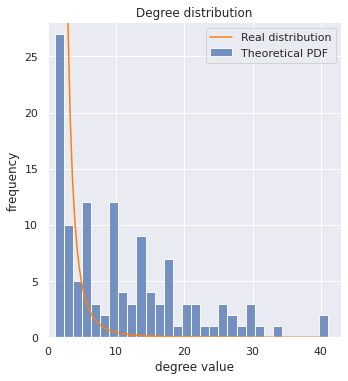

In [ ]:
x_space = np.linspace(1, np.max(degree_values), len(degree_values))
sns.set()
sns.displot(data=np.array(degree_values), bins=30)
plt.plot(x_space, power_law_pdf(x_space, alpha, xmin), c='tab:orange')
plt.ylim(0, 28)
plt.xlim(0,43)
plt.legend(labels=["Real distribution","Theoretical PDF"])
plt.xlabel('degree value')
plt.ylabel('frequency')
plt.title('Degree distribution')
plt.show()

This distribution resembles Power Law. Estimated parameters: α = 3.4, $x_{min} = 13$ *(fitted by MLE)*

In [ ]:
av_clust = nx.average_clustering(graph)
print(f"average clustering coefficient = {round(av_clust,4)}")

average clustering coefficient = 0.5469


In [ ]:
global_clust = nx.transitivity(graph)
print(f"global clustering coefficient = {round(global_clust,4)}")

global clustering coefficient = 0.5047


In [ ]:
clustering = list(nx.clustering(graph).values())

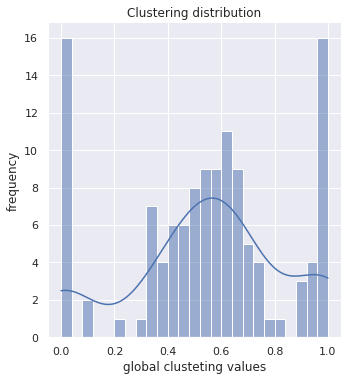

In [ ]:
sns.set()
ax = sns.displot(data=np.array(clustering),bins=25, kde=True)
ax.set(xlabel='global clusteting values', ylabel='frequency')
ax.set(title='Clustering distribution')
plt.show()

***Centrality measures***

In [ ]:
import pandas as pd

In [ ]:
def top_centralities(graph, number=5):

    def get_top_of_centralities(centr_dict):
      sorted_items = sorted(centr_dict.items(), key=lambda kv: kv[1], reverse=True)[:number]
      res = []
      for id, value in sorted_items:
        res.append((my_friends_names_eng[id], value))
      return res

    top_degrees = get_top_of_centralities(nx.degree_centrality(graph))
    top_closeness = get_top_of_centralities(nx.closeness_centrality(graph))
    top_betweenness = get_top_of_centralities(nx.betweenness_centrality(graph))
    top_katz = get_top_of_centralities(nx.katz_centrality_numpy(graph))
    top_eigenvector = get_top_of_centralities(nx.eigenvector_centrality(graph))

    return {'degree':top_degrees, 'closeness': top_closeness, 'betweenness':top_betweenness,
            'eigenvector':top_eigenvector, 'katz':top_katz}

In [ ]:
def get_df_from_centralities(graph):
  df = pd.DataFrame(index = sorted(list(graph.nodes)))
  df['degree'] = [el[1] for el in sorted(nx.degree_centrality(graph).items(), key=lambda kv: kv[0])]
  df['closeness'] = [el[1] for el in sorted(nx.closeness_centrality(graph).items(), key=lambda kv: kv[0])]
  df['betweenness'] = [el[1] for el in sorted(nx.betweenness_centrality(graph).items(), key=lambda kv: kv[0])]
  df['eigenvector'] = [el[1] for el in sorted(nx.eigenvector_centrality(graph).items(), key=lambda kv: kv[0])]
  df['katz'] = [el[1] for el in sorted(nx.katz_centrality_numpy(graph).items(), key=lambda kv: kv[0])]
  return df

In [ ]:
df_centralities = get_df_from_centralities(graph)

In [ ]:
corr = df_centralities.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,degree,closeness,betweenness,eigenvector,katz
degree,1.000,0.617,0.177,0.889,0.459
closeness,0.617,1.000,0.280,0.650,0.074
betweenness,0.177,0.280,1.000,0.061,-0.039
eigenvector,0.889,0.650,0.061,1.000,0.175
katz,0.459,0.074,-0.039,0.175,1.000


As we can see, the best correlated features are *degree* and *eigenvector*, least correlated - *katz* and *betweenness*

In [ ]:
top_dfs = top_centralities(graph)

In [ ]:
!pip install prettytable

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()

In [ ]:
table.field_names = ["Degree", "Closeness", "Betweenness", "Eigenvector", "Katz"]

In [ ]:
for i in range(5):
  table.add_row([top_dfs['degree'][i][0], top_dfs['closeness'][i][0],top_dfs['betweenness'][i][0], top_dfs['eigenvector'][i][0],top_dfs['katz'][i][0]])

In [ ]:
print(table)

+------------------+------------------+---------------------+--------------------+----------------------+
|      Degree      |    Closeness     |     Betweenness     |    Eigenvector     |         Katz         |
+------------------+------------------+---------------------+--------------------+----------------------+
| Anja Sinjavskaja | Jana Beletskaja  |   Jana Beletskaja   |   Anjutka Sorova   |      Nikita Kim      |
|  Anjutka Sorova  | Roman Sosnovskij | Aleksandra Tkacheva |  Anja Sinjavskaja  | Ekaterina Vodovskova |
|  Vlad Mel'nikov  | Vova Buhtijchuk  |   Ekaterina Popova  |   Vlad Mel'nikov   |   Zlata Slutskaja    |
| Vova Buhtijchuk  | Varvara Soboleva |    Egor Solov'ev    |  Vova Buhtijchuk   |    Jurij Neznanov    |
|    Vlad Orlov    | Vanja Skrypnikov |     Valera Semin    | Daniil Kudrjavtsev |    Denis Nikulin     |
+------------------+------------------+---------------------+--------------------+----------------------+


***Top Centralities nodes description:*** 

*   *Top Degree centrality* shows the people that have the most  count of connections. All people from this top are from my biggest community - from BMSTU (my first university)
*   *Top Closeness centrality* shows the people that closely related to others. All people from this top are also from  from BMSTU
*  The top 1 from *betweenness centrality* shows is a person that can be can be in two biggest clusters at the same time: Jana is both from my school and from my university. So this result can be easily explained
*  Eigenvector and Katz centrality describe the relative importance of nodes. Top nodes shows people that friends with many "important" people. All Eigenvector top - from university, all Katz top - from school



In [ ]:
top_dfs['degree']

[('Anja Sinjavskaja', 0.33606557377049184),
 ('Anjutka Sorova', 0.3278688524590164),
 ("Vlad Mel'nikov", 0.27049180327868855),
 ('Vova Buhtijchuk', 0.2540983606557377),
 ('Vlad Orlov', 0.24590163934426232)]

In [ ]:
top_dfs['closeness']

[('Jana Beletskaja', 0.37404371584699453),
 ('Roman Sosnovskij', 0.3606850117096019),
 ('Vova Buhtijchuk', 0.3556049411221427),
 ('Varvara Soboleva', 0.35311819328212773),
 ('Vanja Skrypnikov', 0.34468192245286183)]

***Node structural equvivalence/similarity***

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def sim_matrices(graph):
  G = nx.convert_node_labels_to_integers(graph)

  def get_adj_matrix(G):
    n = len(G.nodes)
    matrix = [[0] * n for i in range(n)]
    for i in range(n):
      for j in range(n):
        if G.has_edge(i,j):
          matrix[i][j] = 1
    return np.array(matrix)

  def get_jaccard_matrix(G):
    n = len(G.nodes)
    jaccard_matrix = [[0] * n for i in range(n)]
    for i in list(G.nodes):
       jaccard_matrix[i][i] = 1
    for i,j, value in nx.jaccard_coefficient(G):
       jaccard_matrix[i][j] = value
    return np.array(jaccard_matrix)

  A = get_adj_matrix(G)
  P = np.corrcoef(A)
  J = get_jaccard_matrix(G)
  C = cosine_similarity(A)
  return A,P,J,C

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import random

In [ ]:
random.seed(25)
random_nodes = random.sample(list(graph.nodes), 35)
subgraph = graph.subgraph(random_nodes)

In [ ]:
A, corr, J, cos = sim_matrices(subgraph)
labs = nx.get_node_attributes(subgraph, "name")

*For visualization of node structural similarity was chosen a random subgraph with 35 nodes (because of a large amount of vertices in my graph)*

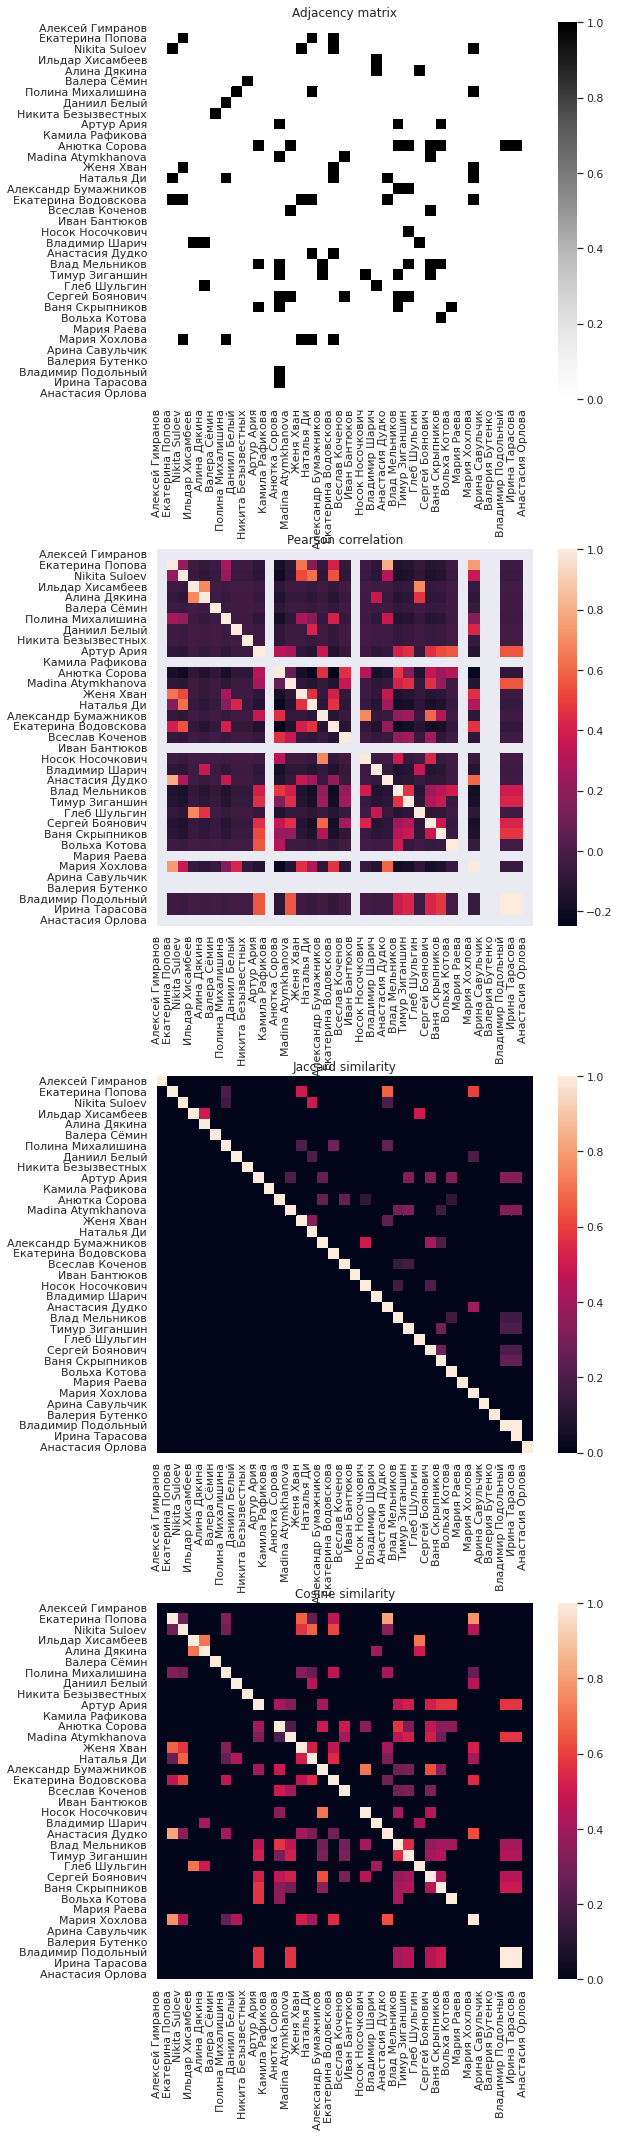

In [ ]:
fig = plt.figure(figsize=(9, 9*4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix'], 
         [2, corr, None, 'Pearson correlation'], 
         [3, J, None, 'Jaccard similarity'], 
         [4, cos, None, 'Cosine similarity'],]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix,
        cmap=cmap,
        square=True,
        yticklabels=[labs.get(i) for i in subgraph.nodes])
    hmap.set_xticklabels(
        labels=[labs.get(i) for i in subgraph.nodes], 
        horizontalalignment='right')
    plt.title(t)

In [ ]:
degree_assort = nx.degree_assortativity_coefficient(graph)
print(f"Degree assortivity coefficient: {round(degree_assort,3)}")

Degree assortivity coefficient: 0.238


In [ ]:
attribute_assort = nx.attribute_assortativity_coefficient(graph,'name')
print(f"Attribute (name) assortivity coefficient: {round(attribute_assort,3)}")

Attribute (name) assortivity coefficient: -0.014


As we can see, the graph has very small name (attribute) assortivity coefficient and that is easily can be explained: there is no dependency between names and possibility of friendship.

***Community detection***

*We will choose parameters for community detection algorithms by maximizing modularity score.*

In [ ]:
import networkx.algorithms.community as nx_comm
'''Function of getting the best parameters of community detection's algorithms 
by maximizing modularity score'''
def get_best_partition_by_modularity(method):
  graph_with_integer_labels = nx.convert_node_labels_to_integers(graph).copy()
  assert method in ['louvain', 'agglomerative','girvan-newman']
  if method == 'louvain':
    best_mod = 0
    best_partition = ()
    for number_of_iterations in range(3,20):
      communities, labels_louvain = get_louvain_params(number_of_iterations)
      current_mod = nx_comm.modularity(graph_with_integer_labels, communities)
      if current_mod > best_mod:
        best_partition = communities, labels_louvain
        best_mod = current_mod
    return best_partition, best_mod, number_of_iterations
  elif method == 'agglomerative':
    distance = simrank_distance(graph_with_integer_labels)
    best_mod = 0
    best_partition = ()
    best_distance = 0
    for max_distance in np.arange(0.7, 0.98, 0.01):
      labels_agglomerative = agglomerative_clustering(distance, max_distance)
      communities = get_communities(labels_agglomerative)
      current_mod = nx_comm.modularity(graph_with_integer_labels, communities)
      if current_mod > best_mod:
        best_mod = current_mod
        best_partition = communities, labels_agglomerative
        best_distance = max_distance
    return best_partition, best_mod, best_distance
  elif method == 'girvan-newman':
    best_mod = 0
    best_partition = ()
    best_n = 0
    for n in range(5,25):
      labels_girvan_newman = edge_betweenness(graph_with_integer_labels, n)[-1]
      communities = get_communities(labels_girvan_newman)
      current_mod = nx_comm.modularity(graph_with_integer_labels, communities)
      if current_mod > best_mod:
        best_mod = current_mod
        best_partition = communities, labels_girvan_newman
        best_n = n
    return best_partition, best_mod, best_n

***1) Agglomerative clustering***

In [ ]:
from sklearn.cluster import AgglomerativeClustering
def simrank_distance(G):
  sim = nx.simrank_similarity(G)
  SimRank = np.array([[sim[u][v] for v in G] for u in G])
  n = len(G)
  simrank =  np.ones((n,n)) - SimRank
  for i in range(n):
    for j in range(n):
      if simrank[i][j] != simrank[j][i]:
         simrank[j][i] = simrank[i][j]
  return simrank

def agglomerative_clustering(distance, max_distance):
  agg = AgglomerativeClustering(distance_threshold=max_distance, linkage='complete',n_clusters=None, affinity='precomputed')
  clustering = agg.fit(distance)
  return clustering.labels_

def get_communities(labels):
  count_communities = labels.max()
  communities = [set() for i in range(count_communities+1)]
  for index, number_community in enumerate(labels):
    communities[number_community].add(index)
  return communities
    

In [ ]:
best_partition_agglomerative, best_mod_agglomerative, best_distance_agglomerative = get_best_partition_by_modularity('agglomerative')
communities_agglomerative, labels_agglomerative = best_partition_agglomerative

In [ ]:
print(f"Best modularity value for agglomerative clustering: {round(best_mod_agglomerative,3)}")
print(f"Max distance: {round(best_distance_agglomerative,3)}")
print(f"Number of clusters: {len(communities_agglomerative)}")

Best modularity value for agglomerative clustering: 0.437
Max distance: 0.88
Number of clusters: 12


In [ ]:
hex_color_list = ['#ff80ed', '#ff4040', '#ffd700', '#00ffff','#d3ffce', '#c6e2ff','#bada55', '#ffb6c1', '#800080', '#ffdab9', '#2acaea', '#8a2be2', '#00ff7f', '#133337','#e6e6fa', '#ffa500']

In [ ]:
from pyvis.network import Network
net = Network()
for i, node in enumerate(list(graph.nodes)):
  net.add_node(node, label=my_friends_names[node], color=hex_color_list[labels_agglomerative[i]])

net.add_edges(edges)
net.repulsion(node_distance=700, spring_length=300)

net.show('graph_vk_agglomerative.html')

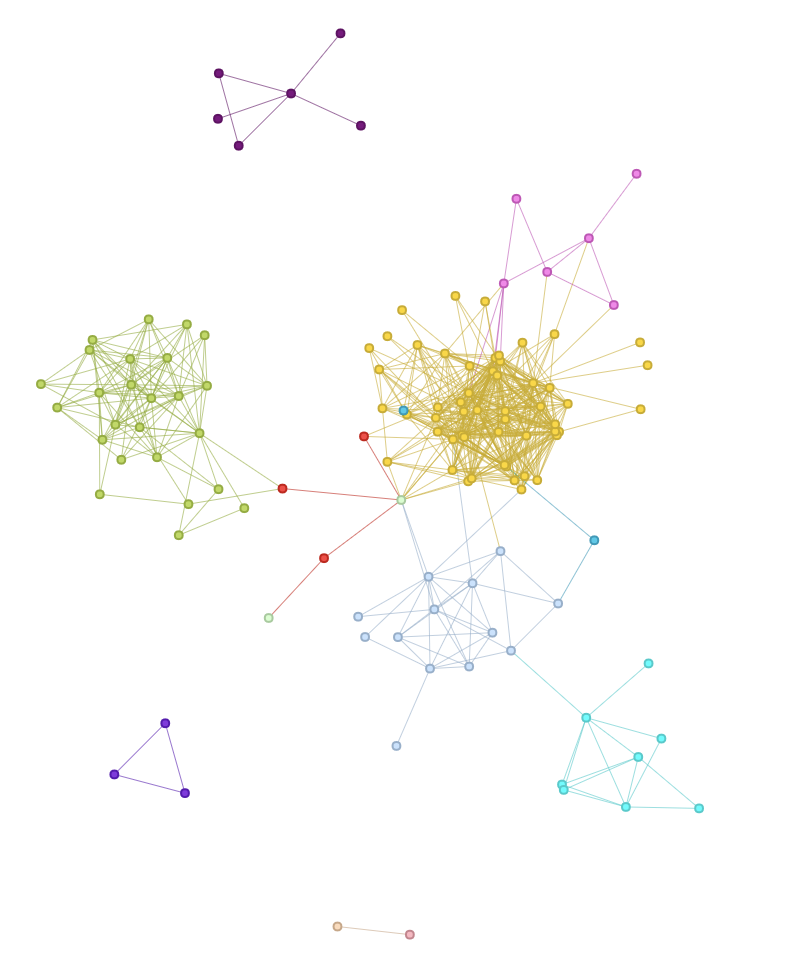

***2) Louvain method***

In [ ]:
def louvain_method(G):
    
    # Phase 1: community unfolding
    communities = unfolded_communities(G)

    # Create labels
    labels = np.zeros(len(G))
    for i, c in enumerate(communities):
        labels[c] = i
    
    # Phase 2: network aggregation
    nextG = nx.empty_graph(len(communities), nx.MultiGraph)
    for e in G.edges:
        nextG.add_edge(labels[int(e[0])], labels[int(e[1])])
       
    return communities, labels, nextG

def unfolded_communities(G):
    A = nx.to_numpy_array(G)
    m = A.sum() / 2
    ee = expected_edges(A, m)
    communities = [[n] for n in G.nodes]
    max_modularity_gain = 1
    for node in G.nodes:
        old_comm = communities[node]
        old_comm.remove(node)
        modularities = []
        for new_comm in communities:
            mod = modularity_gain(A, ee, node, old_comm, new_comm, m)
            modularities.append(mod)
        max_modularity_gain = max(modularities)
        if max_modularity_gain==0:
            communities[node].append(node)
        else:
            i = modularities.index(max_modularity_gain)
            communities[i].append(node)

    return [c for c in communities if len(c)>0]

def expected_edges(A, m):
    output = np.zeros(A.shape)
    for i in range(len(A)):
        for j in range(len(A[i])):
            output[i][j] = np.sum(A[i])*np.sum(A[j])/2/m
    return output

def modularity_gain(A, ee, mnode, old_comm, new_comm, m):
    Aij_cnew = A[mnode][new_comm]
    ei_cnew = ee[mnode][new_comm]
    sum_cnew = np.sum(Aij_cnew - ei_cnew)
    Aij_cold = A[mnode][old_comm]
    ei_cold = ee[mnode][old_comm]
    sum_cold = np.sum(Aij_cold - ei_cold)
    
    return (sum_cnew-sum_cold)/m

In [ ]:
def get_louvain_params(number_of_iterations):
  iterG = nx.convert_node_labels_to_integers(graph).copy()
  prev_comm, labels, iterG = louvain_method(iterG)
  for i in range(number_of_iterations):
      next_comm, labels, iterG = louvain_method(iterG)
      communities = []
      for c in next_comm:
          temp = []
          for node in c:
              temp.extend(prev_comm[node])
          communities.append(temp)
      prev_comm = communities.copy()
  labels = np.zeros(len(graph))
  for i, c in enumerate(communities):
      labels[c] = i
  return [set(community) for community in communities], [int(cluster) for cluster in labels]

In [ ]:
best_partition_louvain, best_mod_louvain, number_of_iterations = get_best_partition_by_modularity('louvain')
communities_louvain, labels_louvain = best_partition_louvain

In [ ]:
print(f"Best modularity value for Louvain method: {round(best_mod_louvain,3)}")
print(f"Number of iterations: {round(number_of_iterations,3)}")
print(f"Number of clusters: {len(communities_louvain)}")

Best modularity value for Louvain method: 0.44
Number of iterations: 19
Number of clusters: 7


In [ ]:
from matplotlib import colors as mcolors
colors = dict(**mcolors.CSS4_COLORS)
colors_values = [el[1] for el in colors.items()]
colors_values_reduced = [colors_values[i] for i in range(len(colors_values)) if i%4==1]
colors_values_reduced.remove('#F5F5DC')

In [ ]:
net = Network()
for i, node in enumerate(list(graph.nodes)):
  net.add_node(node, label=my_friends_names[node], color=colors_values_reduced[labels_louvain[i]])

net.add_edges(edges)
net.repulsion(node_distance=700, spring_length=300)

net.show('graph_louvain.html')

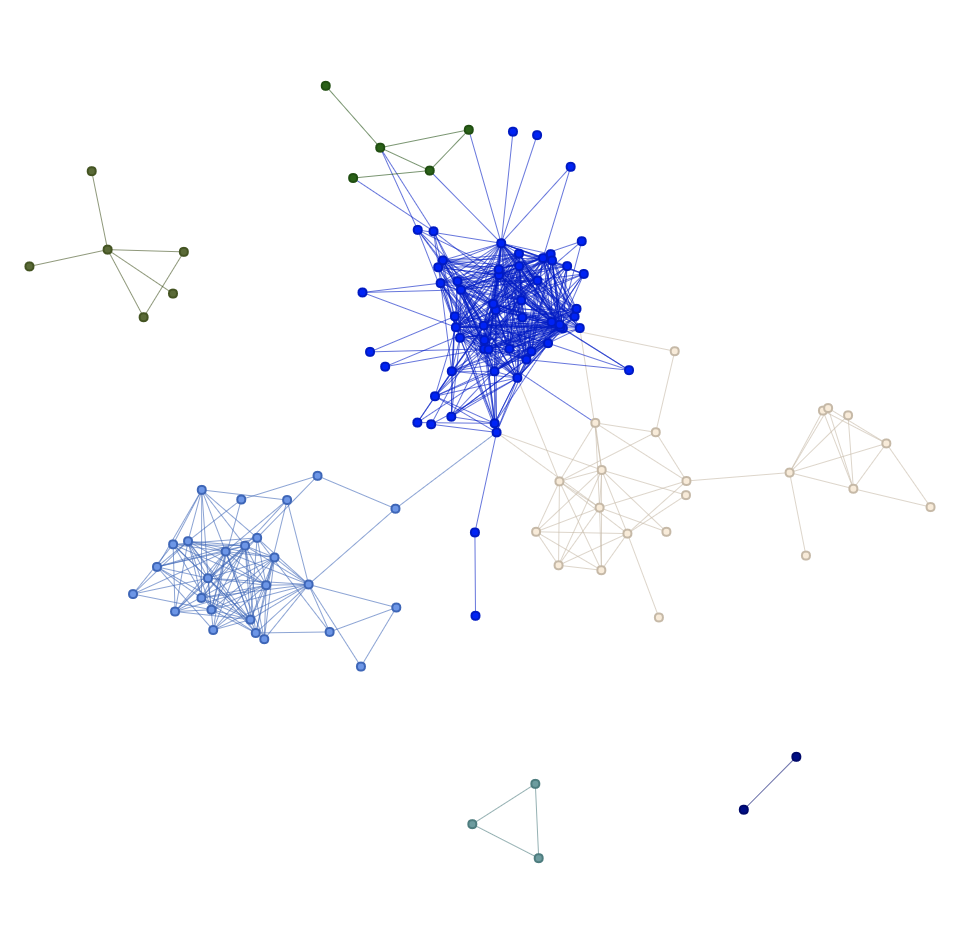

***3) Girvan-Newman algorithm***

In [ ]:
from networkx.algorithms.community import girvan_newman
import itertools

def edge_betweenness(G, n):

    labels = []
    comp = girvan_newman(G)
    for communities in itertools.islice(comp, n):
      components = tuple(sorted(c) for c in communities)
      current_labels = [0]*len(G.nodes)
      for index, component in enumerate(tuple(sorted(c) for c in communities)):
        for node in component:
          current_labels[node] = index
      labels.append(current_labels)

    return np.array(labels)

In [ ]:
best_partition_girvan_newman, best_mod_girvan_newman, best_n = get_best_partition_by_modularity('girvan-newman')

In [ ]:
communities_girvan_newman, labels_girvan_newman = best_partition_girvan_newman

In [ ]:
print(f"Best modularity value for Girvan-Newman method: {round(best_mod_girvan_newman,3)}")
print(f"N: {round(best_n,3)}")
print(f"Number of clusters: {len(communities_girvan_newman)}")

Best modularity value for Girvan-Newman method: 0.442
N: 5
Number of clusters: 9


In [ ]:
net = Network()
for i, node in enumerate(list(graph.nodes)):
  net.add_node(node, label=my_friends_names[node], color=colors_values_reduced[labels_girvan_newman[i]])

net.add_edges(edges)
net.repulsion(node_distance=700, spring_length=300)

net.show('graph_girvan_newman.html')

As we can see, the best algorithm for community detection by maximizing modularity score is Girvan-Newman algorithm.
The biggest two clusters are my friends from my first university - BMSTU and from my school

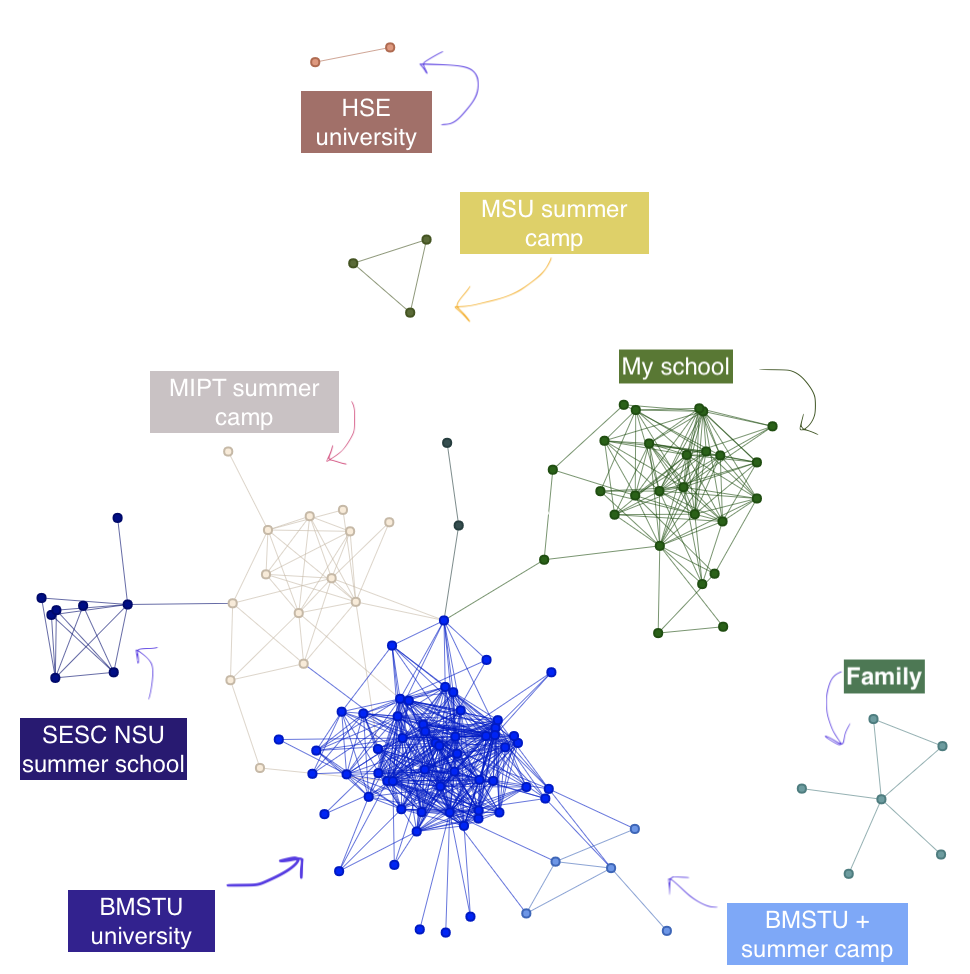

In [ ]:
net = Network()
for i, node in enumerate(list(graph.nodes)):
  net.add_node(node, label=my_friends_names[node])

net.add_edges(edges)
net.repulsion(node_distance=700, spring_length=300)
net.show_buttons(filter_=True)

net.show('graph_vk.html')

As we can see, the best algorithm for community detection by maximizing modularity score is Girvan-Newman algorithm.
The biggest two clusters are my friends from my first university - BMSTU and from my school.

***Clique search, k-cores visualization***

***k-cores***

In [ ]:
def get_maximal_k():
  degrees = np.array(degree_values)
  for k in range(1,degrees.max()):
    new_graph = nx.k_core(graph, k)
    net = Network()
    new_nodes = list(new_graph.nodes)
    new_edges = list(new_graph.edges)
    if len(new_edges) == 0:
      return f"the maximum k is {k - 1}"

In [ ]:
print(get_maximal_k())

the maximum k is 13


In [ ]:
k = 13
new_graph = nx.k_core(graph, k)
net = Network()
new_nodes = list(new_graph.nodes)
new_edges = list(new_graph.edges)

for node in list(new_graph.nodes):
    net.add_node(node, label=my_friends_names[node])
net.add_edges(list(new_graph.edges))
net.repulsion(node_distance=700, spring_length=300)
net.show(f'{k}-core.html')

In [ ]:
len(new_graph.nodes)

28

In [ ]:
visualize_k_cores()

'the maximum k is 13'

13-core visualization:


In [ ]:
from networkx.algorithms.approximation import clique
clique_nodes = clique.max_clique(graph)

In [ ]:
print(f"The maximal clique consist of {len(clique_nodes)} nodes")

The maximal clique consist of 9 nodes


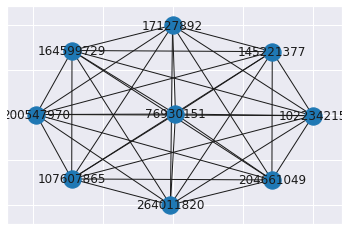

In [ ]:
clique = graph.subgraph(clique_nodes)
nx.draw_networkx(clique)

In [ ]:
net = Network()
for i, node in enumerate(list(clique.nodes)):
  net.add_node(node, label=my_friends_names[node])

net.add_edges(list(clique.edges))
net.repulsion(node_distance=700, spring_length=300)
net.show('clique.html')

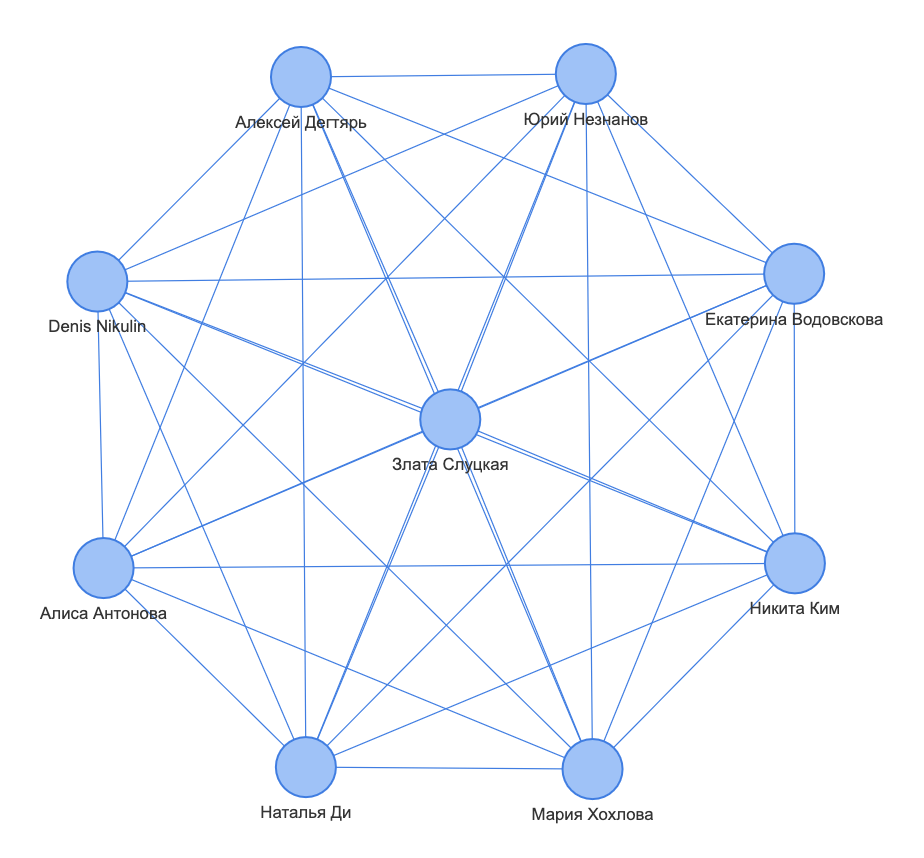

My maximal clique consists of 9 nodes. It's easy to interpret the result - all these friends know each other, because they are classmates.

After full analysis of my ego-graph we can obtain that graph can reffered to *small-world model* because of small average path length and small diameter and to *transitive* model because of high clustering coefficient.